In [2]:
import numpy as np
import torch
import torch.nn as nn
from PIL import Image

img = Image.open('/tmp/skoroki/datasets/ffhq/thumbnails128x128/00000.png')

In [214]:
import math
from tqdm import tqdm
from torch import Tensor
from typing import Tuple, List


class Triangle:
    def __init__(self, v0, v1, v2):
        self.v0 = v0
        self.v1 = v1
        self.v2 = v2
        
    def get_min_pos(self):
        return (
            min(self.v0[0].item(), self.v1[0].item(), self.v2[0].item()),
            min(self.v0[1].item(), self.v1[1].item(), self.v2[1].item())
        )
    
    def get_max_pos(self):
        return (
            max(self.v0[0].item(), self.v1[0].item(), self.v2[0].item()),
            max(self.v0[1].item(), self.v1[1].item(), self.v2[1].item())
        )
    
    def compute_color(self, bar_coords: Tuple[float, float, float], img: Tensor):
        return self.get_color(self.v0, img) * bar_coords[0] + \
               self.get_color(self.v1, img) * bar_coords[1] + \
               self.get_color(self.v2, img) * bar_coords[2]
    
    def get_edge(self, edge_idx: int):
        if edge_idx == 0:
            return self.v2 - self.v1
        elif edge_idx == 1:
            return self.v0 - self.v2
        else:
            return self.v1 - self.v0
    
    def get_color(self, vertex, img):
        return img[vertex[1].round().long().item()][vertex[0].round().long().item()]
        
        
# class Vertex:
#     def __init__(self, x, y, color: Tensor):
#         self.pos = (x, y)
#         self.color = color


def triangle_interpolation(coords: Tensor, img: Tensor):
    """
    Takes a full image, selects coordinates from it and performs the interpolation
    Coords have the shape [grid_height, grid_width, 2]
    """
    grid_height, grid_width = coords.shape[0], coords.shape[1]
    
    # Let's collect the triangles first
    print('Collecting triangles...')
    triangles = []
    for i in range(grid_height - 1):
        for j in range(grid_width - 1):
            if i % 2 == j % 2:
                v0, v1, v2 = coords[i][j], coords[i+1][j+1], coords[i+1][j]
                u0, u1, u2 = coords[i][j], coords[i][j+1], coords[i+1][j+1]
            else:
                v0, v1, v2 = coords[i][j], coords[i][j+1], coords[i+1][j]
                u0, u1, u2 = coords[i+1][j], coords[i][j+1], coords[i+1][j+1]

#             if i % 2 == j % 2:
#                 v0, v1, v2 = coords[j][i], coords[j+1][i+1], coords[j][i+1]
#                 u0, u1, u2 = coords[j][i], coords[j+1][i], coords[j+1][i+1]
#             else:
#                 v0, v1, v2 = coords[j][i], coords[j+1][i], coords[j][i+1]
#                 u0, u1, u2 = coords[j][i+1], coords[j+1][i], coords[j+1][i+1]
            
            triangles.append(Triangle(v0, v1, v2))
            triangles.append(Triangle(u0, u1, u2))
    
    # Then, we loop over the triangles and rasterize them using barycentric coordinates
    return rasterize_triangles(triangles, img.shape[0], img.shape[1], img)
    
    
def rasterize_triangles(triangles: List[Triangle], h, w, full_image: Tensor) -> Tensor:
    """
    Takes the triangles and rasterizes them to a given height and width.
    Also takes the full image for querying colors
    """
    result = torch.zeros_like(full_image)
#     num_repeated_pixels = 0
    
    for triangle_idx, triangle in tqdm(enumerate(triangles), desc=f'Rasterizing {len(triangles)} triangles', total=len(triangles)):
        min_pos, max_pos = triangle.get_min_pos(), triangle.get_max_pos()
        triangle_area = compute_det_from_points(triangle.v0, triangle.v1, triangle.v2);
        
        #print('Triangle:', triangle.v0, triangle.v1, triangle.v2)
        
        for y in range(math.floor(min_pos[1]), math.ceil(max_pos[1]) + 1):
            for x in range(math.floor(min_pos[0]), math.ceil(max_pos[0]) + 1):
                pixel_pos = (x, y)
                bar_coords_raw = (
                    compute_det_from_points(triangle.v1, triangle.v2, pixel_pos),
                    compute_det_from_points(triangle.v2, triangle.v0, pixel_pos),
                    compute_det_from_points(triangle.v0, triangle.v1, pixel_pos),
                )
                #print(f'Bar coords', bar_coords_raw)

                if bar_coords_raw[0] < 0 or bar_coords_raw[1] < 0 or bar_coords_raw[2] < 0:
                    continue
                    
                # Perform top-left check
#                 if bar_coords_raw[0] == 0:
#                     if not check_top_left_rule(triangle.get_edge(0)):
#                         print(f'[{triangle_idx}] skip {x}, {y} for v0', triangle.get_edge(0))
#                         continue
#                 if bar_coords_raw[1] == 0:
#                     if not check_top_left_rule(triangle.get_edge(1)):
#                         print(f'[{triangle_idx}] skip {x}, {y} for v1', triangle.get_edge(1))
#                         continue
#                 if bar_coords_raw[2] == 0:
#                     if not check_top_left_rule(triangle.get_edge(2)):
#                         print(f'[{triangle_idx}] skip {x}, {y} for v2', triangle.get_edge(2))
#                         continue

                area = sum(bar_coords_raw)
                bar_coords = (bar_coords_raw[0] / area, bar_coords_raw[1] / area, bar_coords_raw[2] / area)
                
#                 if result[y][x].abs().sum() != 0:
#                     num_repeated_pixels += 1
#                     print(f'We have already colored this pixel ({x}, {y}):', result[y][x])
                #print(f'Setting color for {y}, {x}:', triangle.compute_color(bar_coords, full_image))
                result[y][x] = triangle.compute_color(bar_coords, full_image)
                #print(triangle.v0, triangle.v1, triangle.v2)

#     print(f'Num pixels filled more than once: {num_repeated_pixels}')
    return result.permute(2, 0, 1)


def check_top_left_rule(edge) -> bool:
    return ((edge[1] == 0 and edge[0] > 0) or (edge[1] > 0))


# def compute_det_from_points(u: Tuple[float, float], v: Tuple[float, float], point: Tuple[float, float]) -> float:
#     return (point[0] - u[0]) * (v[1] - u[1]) - (point[1] - u[1]) * (v[0] - u[0])

def compute_det_from_points(A: Tuple[float, float], B: Tuple[float, float], C: Tuple[float, float]) -> float:
    # Compute the signed area of the triangle spanned by vectors AB, AC
#     AB = B - A
#     AC = C - A
#     return AB[0] * AC[1] - AB[1] * AC[0]
    return ((B[0] - A[0]) * (C[1] - A[1]) - (B[1] - A[1]) * (C[0] - A[0])) / 2

Rasterizing 8 triangles: 100%|██████████| 8/8 [00:00<00:00, 203.73it/s]

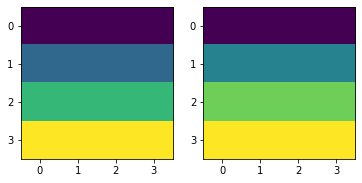

In [215]:
img = torch.linspace(0, 1, 4).view(-1, 1).repeat(1, 4).unsqueeze(2)
x_coords = torch.tensor([0.0, 1.5, 3.0]).view(1, -1).repeat(3, 1).float()
coords = torch.stack([x_coords, x_coords.t()]).permute(1, 2, 0)
# img = torch.linspace(0, 1, 2).view(-1, 1).repeat(1, 2).unsqueeze(2)
# x_coords = torch.tensor([0.0, 1.0]).view(1, -1).repeat(2, 1).float()
# coords = torch.stack([x_coords, x_coords.t()]).permute(1, 2, 0)
result = triangle_interpolation(coords, img)

import matplotlib.pyplot as plt

plt.subplot(121)
plt.imshow(img.squeeze(2))

plt.subplot(122)
plt.imshow(result.squeeze(0))

In [216]:
import torchvision.transforms.functional as TVF

img = Image.open('/tmp/skoroki/datasets/ffhq/thumbnails128x128/00000.png').convert('LA')
img = TVF.to_grayscale(img)
img = torch.from_numpy(np.array(img)).unsqueeze(2)
img_size = img.shape[0]
grid_size = img_size // 2
x_coords = torch.linspace(0.49, img_size - 0.51, grid_size).view(1, -1).repeat(grid_size, 1).float()
# x_coords = torch.arange(0, 127, 2).view(1, -1).repeat(grid_size, 1).float()
coords = torch.stack([x_coords, x_coords.t()]).permute(1, 2, 0)
result = triangle_interpolation(coords, img)

Rasterizing 7938 triangles:   0%|          | 0/7938 [00:00<?, ?it/s]

Rasterizing 7938 triangles: 100%|██████████| 7938/7938 [00:26<00:00, 304.26it/s]


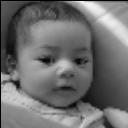

In [217]:
TVF.to_pil_image(result)

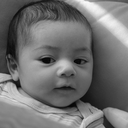

In [109]:
TVF.to_pil_image(img.permute(2, 0, 1))